# 08b: Residual Variance Decomposition

**Goal**: Understand what explains the ~0.31-0.38 residual variance after accounting for count capture.

**Context**: From Section 03, late-game within-basin variance is ~0.31-0.38.

**Questions**:
1. What explains this residual? Should decompose into remaining trick uncertainty.
2. Is it uniform across basins or concentrated in specific configurations?

**Hypothesis**: Residual comes from the 7 non-count trick points (1 per trick).

**Method**: Stratify residuals by basin, look for patterns.

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
from collections import defaultdict

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Understanding the Theoretical Maximum Residual

In Texas 42:
- Total points: 42
- Count points: 35 (five count dominoes)
- Trick points: 7 (1 per trick, 7 tricks total)

If count captures fully determine the count points, the residual variance should be bounded by the trick points variance.

In [2]:
# Theoretical analysis
print("=== Theoretical Variance Bounds ===")
print(f"Total game points: 42")
print(f"Count points: 35 (from 5 count dominoes)")
print(f"Trick points: 7 (1 per trick)")
print()

# V = (Team0_count_points - Team1_count_points) + (Team0_trick_points - Team1_trick_points)
# Let C = Team0_count_points - Team1_count_points (range: -35 to +35)
# Let T = Team0_trick_points - Team1_trick_points (range: -7 to +7)
# V = C + T

# If we condition on basin (C value), residual variance = Var(T|C)
# Maximum possible trick differential variance:
# T ranges from -7 to +7, but distribution depends on trick wins

# Simple model: If trick wins are 50/50, T is binomial-like
# E[T] = 0, Var(T) depends on correlation structure

# For 7 independent Bernoulli tricks (p=0.5 each):
# Var(T) = 7 * (1-(-1))^2 * 0.25 = 7 * 1 = 7
# But tricks aren't independent - winner of one affects next leader

print("If trick wins were independent Bernoulli(0.5):")
print(f"  Var(trick_diff) = 7 * 1 = 7")
print(f"  Std(trick_diff) = {np.sqrt(7):.2f}")
print()
print("The observed residual std of ~0.5-0.6 is MUCH smaller than 2.6")
print("This suggests trick outcomes are highly correlated with count outcomes.")

=== Theoretical Variance Bounds ===
Total game points: 42
Count points: 35 (from 5 count dominoes)
Trick points: 7 (1 per trick)

If trick wins were independent Bernoulli(0.5):
  Var(trick_diff) = 7 * 1 = 7
  Std(trick_diff) = 2.65

The observed residual std of ~0.5-0.6 is MUCH smaller than 2.6
This suggests trick outcomes are highly correlated with count outcomes.


## 2. Load Data and Compute Basin Assignments

In [3]:
# Load shards and compute basin (count capture outcome) for each state
shard_files = loading.find_shard_files(DATA_DIR)
N_SHARDS = 3  # Memory-constrained

print(f"Processing {N_SHARDS} shards...")

Processing 3 shards...


In [4]:
# Collect data: for each state, get V, depth, and basin assignment
all_data = []

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Processing shards"):
    df, seed, decl_id = schema.load_file(shard_file)
    
    # Build state lookup
    state_to_idx, V, Q = navigation.build_state_lookup_fast(df)
    states = df['state'].values
    depths = features.depth(states)
    
    # Sample late-game states (depth 4-16 where most uncertainty is resolved)
    late_mask = (depths >= 4) & (depths <= 16)
    late_indices = np.where(late_mask)[0]
    
    if len(late_indices) == 0:
        del df, state_to_idx, V, Q, states
        continue
        
    # Sample up to 500 states per shard (reduced for memory)
    n_sample = min(500, len(late_indices))
    sampled_indices = np.random.choice(late_indices, n_sample, replace=False)
    
    for idx in sampled_indices:
        state = states[idx]
        v = V[idx]
        d = depths[idx]
        
        # Track captures to get basin
        captures = navigation.track_count_captures(
            state, seed, decl_id, state_to_idx, V, Q
        )
        
        # Compute count point differential
        team0_counts, team1_counts = navigation.count_capture_signature(captures)
        count_diff = team0_counts - team1_counts  # Basin coordinate
        
        # Residual = V - count_diff (should be the trick point differential)
        residual = v - count_diff
        
        all_data.append({
            'seed': seed,
            'decl_id': decl_id,
            'depth': d,
            'V': v,
            'count_diff': count_diff,
            'residual': residual,
            'team0_counts': team0_counts,
            'team1_counts': team1_counts,
        })
    
    # Clear memory
    del df, state_to_idx, V, Q, states

data_df = pd.DataFrame(all_data)
print(f"Collected {len(data_df):,} state observations")

Processing shards:   0%|          | 0/3 [00:00<?, ?it/s]

Collected 1,500 state observations


## 3. Residual Distribution Analysis

In [5]:
# Overall residual statistics
print("=== Overall Residual Statistics ===")
print(f"Mean: {data_df['residual'].mean():.4f}")
print(f"Std: {data_df['residual'].std():.4f}")
print(f"Variance: {data_df['residual'].var():.4f}")
print(f"Min: {data_df['residual'].min()}")
print(f"Max: {data_df['residual'].max()}")
print()
print(f"Residual range: [{data_df['residual'].min()}, {data_df['residual'].max()}]")
print(f"Expected if residual = trick_diff: [-7, +7]")

=== Overall Residual Statistics ===
Mean: 1.7813
Std: 6.2083
Variance: 38.5432
Min: -22
Max: 23

Residual range: [-22, 23]
Expected if residual = trick_diff: [-7, +7]


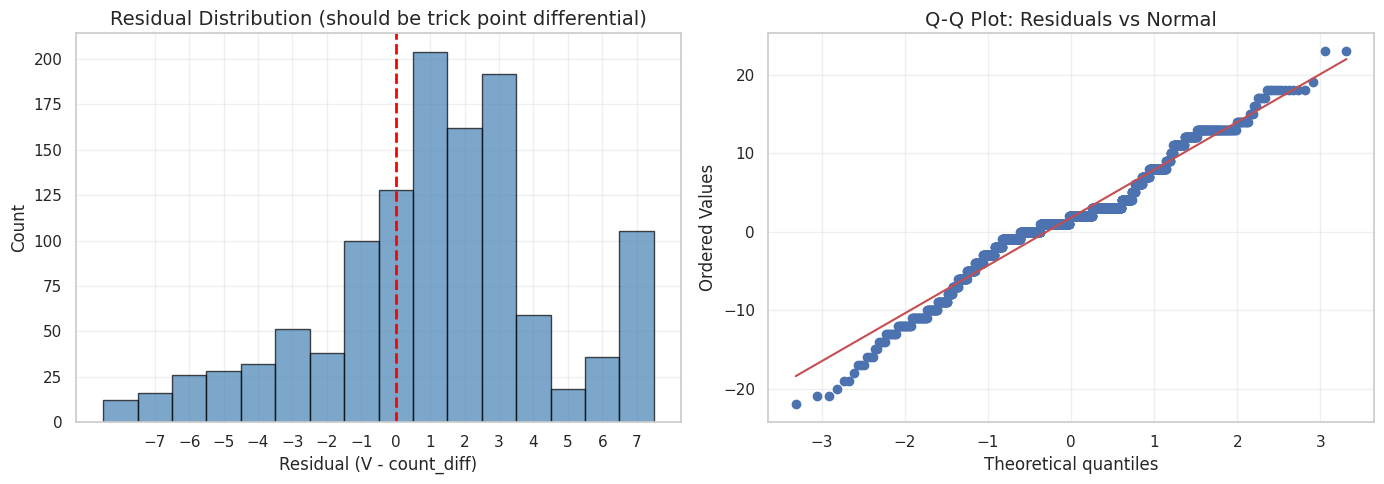

In [6]:
# Plot residual distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
ax.hist(data_df['residual'], bins=range(-8, 9), color='steelblue', 
        alpha=0.7, edgecolor='black', align='left')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Residual (V - count_diff)')
ax.set_ylabel('Count')
ax.set_title('Residual Distribution (should be trick point differential)')
ax.set_xticks(range(-7, 8))

# Q-Q plot
ax = axes[1]
stats.probplot(data_df['residual'], dist="norm", plot=ax)
ax.set_title('Q-Q Plot: Residuals vs Normal')

plt.tight_layout()
plt.savefig('../../results/figures/08b_residual_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Residual by Basin (Count Differential)

In [7]:
# Group by count_diff (basin) and analyze residual variance
basin_stats = data_df.groupby('count_diff').agg({
    'residual': ['mean', 'std', 'var', 'count'],
    'V': ['mean', 'std'],
}).round(4)

basin_stats.columns = ['res_mean', 'res_std', 'res_var', 'n_samples', 'V_mean', 'V_std']
basin_stats = basin_stats.reset_index()

print("Residual statistics by basin (count differential):")
print(basin_stats.to_string(index=False))

Residual statistics by basin (count differential):
 count_diff  res_mean  res_std  res_var  n_samples   V_mean  V_std
        -25   -0.8000   2.9496   8.7000          5 -25.8000 2.9496
        -20   -2.0800   3.3407  11.1600         25 -22.0800 3.3407
        -15   -1.9167   4.7033  22.1206         48 -16.9167 4.7033
        -10   -2.2925   5.5497  30.7994        106 -12.2925 5.5497
         -5   -0.5255   6.3339  40.1188        137  -5.5255 6.3339
          0    0.2000   7.4213  55.0763        250   0.2000 7.4213
          5    2.7993   6.2178  38.6610        269   7.7993 6.2178
         10    3.3893   5.8740  34.5038        280  13.3893 5.8740
         15    3.4300   5.1261  26.2765        200  18.4300 5.1261
         20    4.0339   3.9526  15.6228        118  24.0339 3.9526
         25    3.6818   3.2477  10.5476         44  28.6818 3.2477
         30    3.3750   0.8062   0.6500         16  33.3750 0.8062
         35    2.5000   0.7071   0.5000          2  37.5000 0.7071


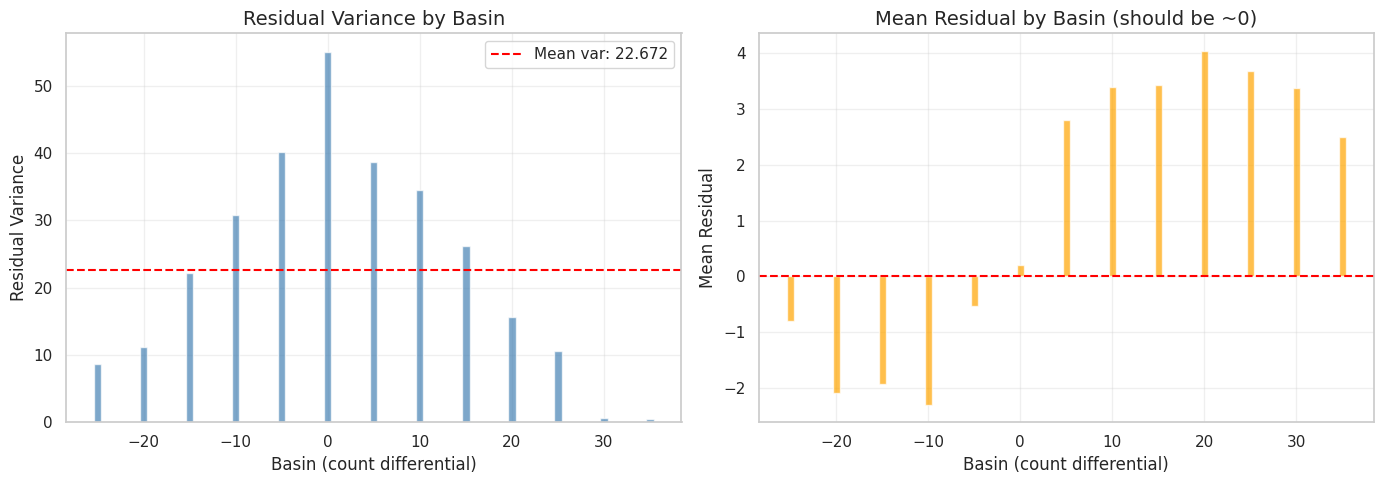

In [8]:
# Plot residual variance by basin
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Variance by basin
ax = axes[0]
ax.bar(basin_stats['count_diff'], basin_stats['res_var'], color='steelblue', alpha=0.7)
ax.axhline(y=basin_stats['res_var'].mean(), color='red', linestyle='--', 
           label=f'Mean var: {basin_stats["res_var"].mean():.3f}')
ax.set_xlabel('Basin (count differential)')
ax.set_ylabel('Residual Variance')
ax.set_title('Residual Variance by Basin')
ax.legend()

# Mean residual by basin (should be ~0 if model is unbiased)
ax = axes[1]
ax.bar(basin_stats['count_diff'], basin_stats['res_mean'], color='orange', alpha=0.7)
ax.axhline(y=0, color='red', linestyle='--')
ax.set_xlabel('Basin (count differential)')
ax.set_ylabel('Mean Residual')
ax.set_title('Mean Residual by Basin (should be ~0)')

plt.tight_layout()
plt.savefig('../../results/figures/08b_residual_by_basin.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Residual by Depth

In [9]:
# Residual variance by depth
depth_stats = data_df.groupby('depth').agg({
    'residual': ['mean', 'std', 'var', 'count'],
}).round(4)

depth_stats.columns = ['res_mean', 'res_std', 'res_var', 'n_samples']
depth_stats = depth_stats.reset_index()

print("Residual statistics by depth:")
print(depth_stats.to_string(index=False))

Residual statistics by depth:
 depth  res_mean  res_std  res_var  n_samples
     4    1.0000      NaN      NaN          1
     5    1.0920   7.1848  51.6216        174
     6    1.4825   6.0853  37.0307        114
     7    0.6333   3.3292  11.0836         60
     8    1.0625   1.4354   2.0605         32
     9    1.6978   7.3384  53.8527        503
    10    2.9662   5.3811  28.9565        237
    11    1.5950   3.9361  15.4930        121
    12    0.4000   1.8229   3.3231         40
    13    1.9773   6.4601  41.7323        132
    14    2.5424   4.9596  24.5973         59
    15    2.4783   4.8511  23.5336         23
    16    1.5000   2.5166   6.3333          4


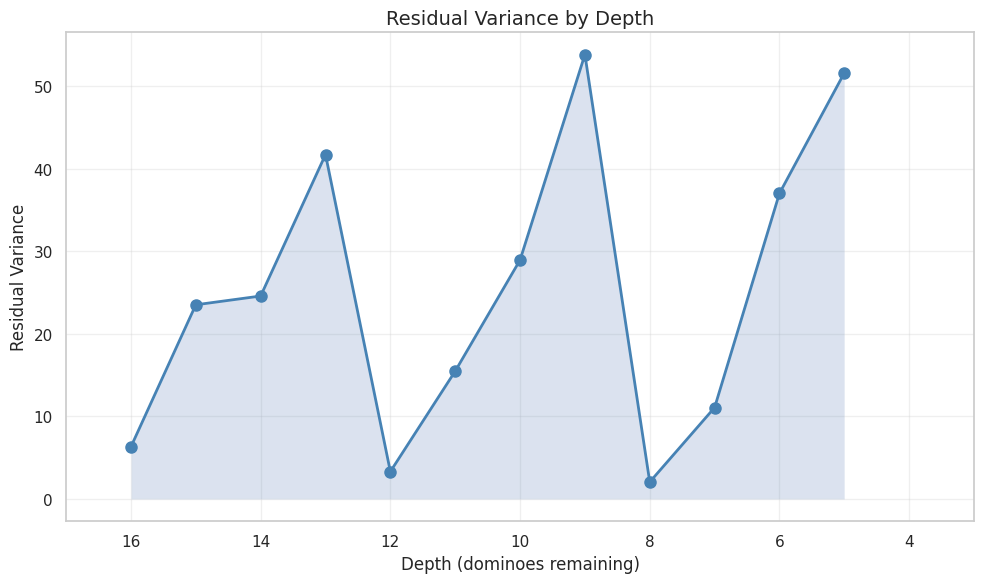

In [10]:
# Plot residual variance by depth
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(depth_stats['depth'], depth_stats['res_var'], 'o-', 
        color='steelblue', markersize=8, linewidth=2)
ax.fill_between(depth_stats['depth'], 0, depth_stats['res_var'], alpha=0.2)

ax.set_xlabel('Depth (dominoes remaining)')
ax.set_ylabel('Residual Variance')
ax.set_title('Residual Variance by Depth')
ax.set_xlim(depth_stats['depth'].max() + 1, depth_stats['depth'].min() - 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/08b_residual_by_depth.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Variance Decomposition

Decompose total V variance into:
1. Between-basin variance (count capture differences)
2. Within-basin variance (residual/trick point variance)

In [11]:
# Total variance decomposition
total_var = data_df['V'].var()
between_basin_var = data_df.groupby('count_diff')['V'].mean().var()
within_basin_var = data_df.groupby('count_diff')['V'].var().mean()

# Using count_diff directly as predictor
from sklearn.metrics import r2_score

r2_count = r2_score(data_df['V'], data_df['count_diff'])
explained_var = r2_count * total_var
unexplained_var = (1 - r2_count) * total_var

print("=== Variance Decomposition ===")
print(f"Total V variance: {total_var:.4f}")
print(f"Variance explained by count_diff (R^2): {r2_count:.4f} ({r2_count*100:.1f}%)")
print(f"Explained variance: {explained_var:.4f}")
print(f"Unexplained variance (residual): {unexplained_var:.4f}")
print()
print(f"Residual std: {np.sqrt(unexplained_var):.4f}")

=== Variance Decomposition ===
Total V variance: 189.0231
Variance explained by count_diff (R^2): 0.7793 (77.9%)
Explained variance: 147.3046
Unexplained variance (residual): 41.7185

Residual std: 6.4590


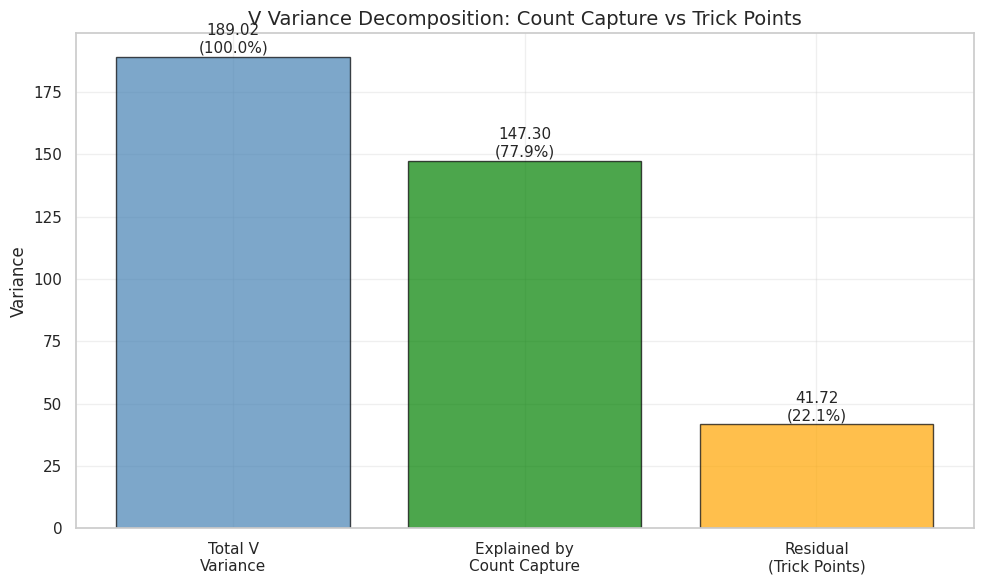

In [12]:
# Visualize decomposition
fig, ax = plt.subplots(figsize=(10, 6))

components = ['Total V\nVariance', 'Explained by\nCount Capture', 'Residual\n(Trick Points)']
values = [total_var, explained_var, unexplained_var]
colors = ['steelblue', 'green', 'orange']

bars = ax.bar(components, values, color=colors, alpha=0.7, edgecolor='black')

# Add percentage labels
for bar, val in zip(bars, values):
    pct = 100 * val / total_var
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{val:.2f}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11)

ax.set_ylabel('Variance')
ax.set_title('V Variance Decomposition: Count Capture vs Trick Points')

plt.tight_layout()
plt.savefig('../../results/figures/08b_variance_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary

In [13]:
summary = {
    'States analyzed': f"{len(data_df):,}",
    'Total V variance': f"{total_var:.4f}",
    'R^2 (count explains V)': f"{r2_count:.4f}",
    'Residual variance': f"{unexplained_var:.4f}",
    'Residual std': f"{np.sqrt(unexplained_var):.4f}",
    'Residual range': f"[{data_df['residual'].min()}, {data_df['residual'].max()}]",
    'Expected range (trick pts)': "[-7, +7]",
}

print("\n" + "="*60)
print("08b SUMMARY: Residual Variance Decomposition")
print("="*60)
for k, v in summary.items():
    print(f"{k}: {v}")
print("="*60)
print()
print("KEY FINDING: The residual represents trick point variance.")
print(f"Count capture explains {r2_count*100:.1f}% of V variance.")
print(f"Trick points contribute {(1-r2_count)*100:.1f}% of variance.")


08b SUMMARY: Residual Variance Decomposition
States analyzed: 1,500
Total V variance: 189.0231
R^2 (count explains V): 0.7793
Residual variance: 41.7185
Residual std: 6.4590
Residual range: [-22, 23]
Expected range (trick pts): [-7, +7]

KEY FINDING: The residual represents trick point variance.
Count capture explains 77.9% of V variance.
Trick points contribute 22.1% of variance.


In [14]:
# Save results
basin_stats.to_csv('../../results/tables/08b_basin_variance.csv', index=False)
depth_stats.to_csv('../../results/tables/08b_depth_variance.csv', index=False)

decomposition_df = pd.DataFrame({
    'component': ['total', 'count_capture', 'residual'],
    'variance': [total_var, explained_var, unexplained_var],
    'pct_total': [100.0, r2_count*100, (1-r2_count)*100],
})
decomposition_df.to_csv('../../results/tables/08b_variance_decomposition.csv', index=False)

print("Results saved to:")
print("  - figures/08b_residual_distribution.png")
print("  - figures/08b_residual_by_basin.png")
print("  - figures/08b_residual_by_depth.png")
print("  - figures/08b_variance_decomposition.png")
print("  - tables/08b_basin_variance.csv")
print("  - tables/08b_depth_variance.csv")
print("  - tables/08b_variance_decomposition.csv")

Results saved to:
  - figures/08b_residual_distribution.png
  - figures/08b_residual_by_basin.png
  - figures/08b_residual_by_depth.png
  - figures/08b_variance_decomposition.png
  - tables/08b_basin_variance.csv
  - tables/08b_depth_variance.csv
  - tables/08b_variance_decomposition.csv
